In this post I shall show how to cluster geographic data using [K-means](https://en.wikipedia.org/wiki/K-means_clustering). First we must import some libraries and get the dataset. For now I'm not really going to worry about using anything other than the Lat/Long values, in later post I'll get to more complex analysis. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import requests
import geopandas as gp
from shapely.geometry import Point

I'll be using  this [L.A. Crime dataset](https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq).  

In [2]:
r=requests.get('https://data.lacity.org/resource/7fvc-faax.geojson')

In [3]:
data=r.json()

features=data['features'] 

This particular dataset requires a little bit of cleaning before going any further. It happens that some of the coordinates are assigned to 0,0. In this case I'm merely using the dataset as an example for clustering, so I'm going to remove the points. In other instances, it may be better to use a different method. 

In [4]:
obj=[]
for i in features:
    corr=i['geometry']['coordinates']
    lon=corr[0]
    lat=corr[1]
    if lat!=0 or lon!=0:
        obj.append((lon,lat))
    else:
        pass
obj    

df=pd.DataFrame(obj, columns=['lon','lat'])
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(df,crs=crs, geometry=geometry)


Next I'm going to project the data into [NAD83 / California zone 5](http://spatialreference.org/ref/epsg/26945/)

In [5]:
gdf = gdf.to_crs({'init': 'epsg:26945'})

As always before going forward I should plot my data, to insure things are okay. Try to imagine how you would like to divide out the clusters so you can compare your ideas with K-means. 

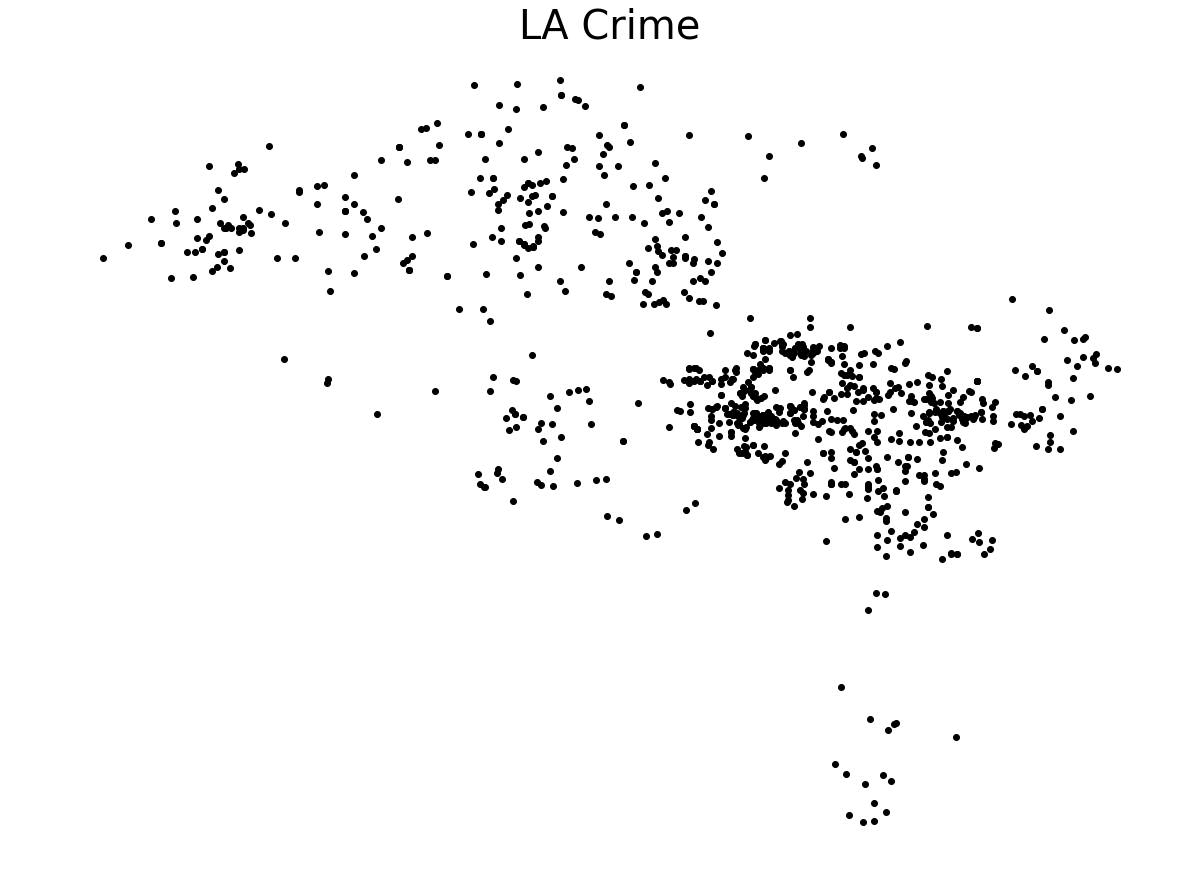

In [6]:
f, ax = plt.subplots(1, figsize=(20, 15))
ax.set_title("LA Crime", fontsize=40)
ax.set_axis_off()
#LA.plot(ax=ax,  edgecolor='grey')
gdf.plot(ax=ax, color='black')
plt.show()

Everything looks good, now let's do some clustering. We'll need to extract the xy values from the geometry field and contruct a numpy array. 

In [7]:
a=pd.Series(gdf['geometry'].apply(lambda p: p.x))
b=pd.Series(gdf['geometry'].apply(lambda p: p.y))
X=np.column_stack((a,b))

Next I'm going to use the elbow method to determine the optimal number of clusters. At some point increasing the number of clusters will only result in marginal gains or the loss of insight. If we selected for the lowest possible variance, then each point would have its own cluster. We're going to look for here is the location of the graph with the greatest change in the within cluster sum of squares (it should look like an elbow). 

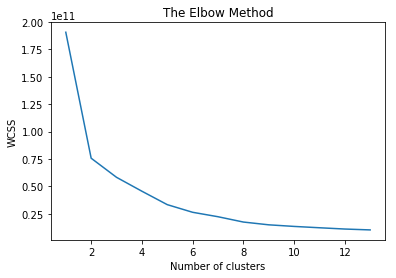

In [8]:
wcss = []
for i in range(1, 14):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 14), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

It would appear the optimal number of clusters is 4, so that's what we'll go with. This is only a suggestion, depending upon the problem it may be logical not to heed the elbow method's guidelines, for example if we were trying to use it as a classifier on 3 known categories while the elbow method suggests 2.

In [9]:
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 5,  max_iter=400)
y_kmeans = kmeans.fit_predict(X)
k=pd.DataFrame(y_kmeans, columns=['cluster'])
gdf=gdf.join(k)

Our data has been clustered and joined back to the GeoDataFrame. Now we're ready to plot the results. 

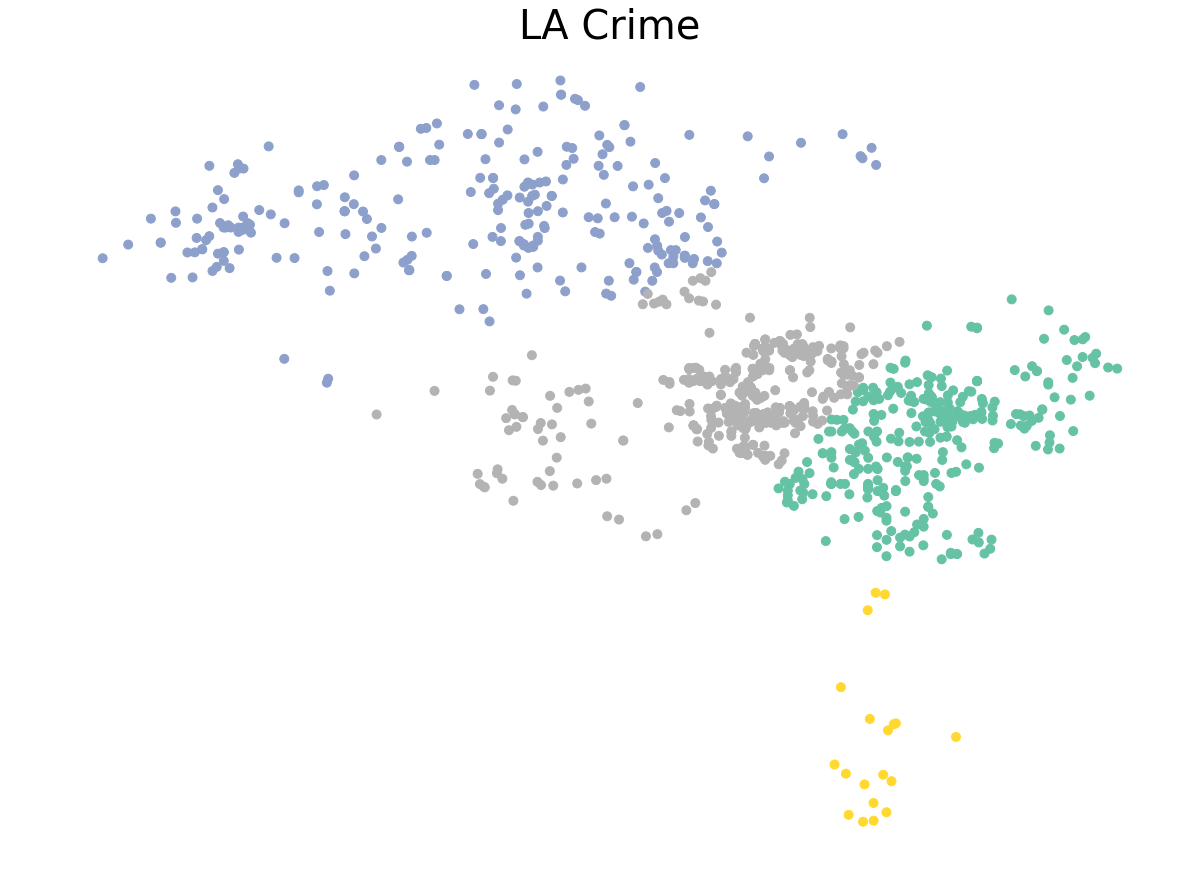

In [10]:
f, ax = plt.subplots(1, figsize=(20, 15))
ax.set_title("LA Crime", fontsize=40)
ax.set_axis_off()
gdf.plot(column='cluster',cmap='Set2', ax=ax, markersize=80)
plt.show()

Do you agree with the results? Are they what you expected? Perhaps we should try increasing the mumber of clusters to see what happens. 

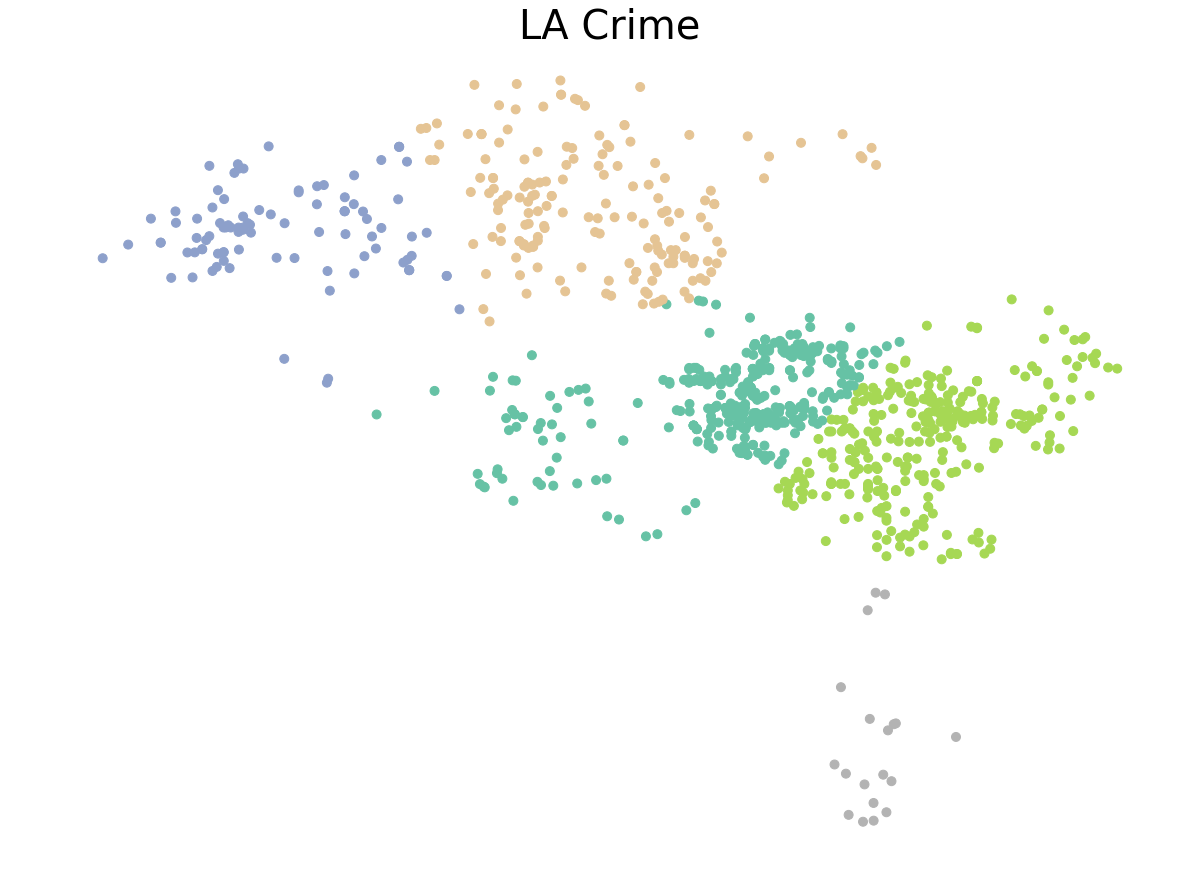

In [11]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', random_state = 5,  max_iter=400)
y_kmeans = kmeans.fit_predict(X)
k5=pd.DataFrame(y_kmeans, columns=['cluster5'])
gdf=gdf.join(k5)

f, ax = plt.subplots(1, figsize=(20, 15))
ax.set_title("LA Crime", fontsize=40)
ax.set_axis_off()
gdf.plot(column='cluster5',cmap='Set2', ax=ax, markersize=80)
plt.show()

What do you think- Is K-means the tool for the job? What is the optimal number of clusters? There's not a simple answer. Problems are often domain specific, perhaps crime data would benefit from having a high number of clusters or maybe clustering simply isn't a useful insight. K-means tends to favor "round" clusters, perhaps that's why the middle section is being dividing in half rather than producing a large oval cluster. In a later post I'll be revisiting this dataset for further analysis to see what additional insights can be gain by using different algorithms and increasing the dimensionality. I'll leave you with a famous quote about statistics. 

"Essentially, all models are wrong, but some are useful"- George Box